In [1]:
# %%writefile random_forest_model.py
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pprint
import string
import re
import datetime
import copy

from my_tools import get_bill_data

import statsmodels.api as sm
import scipy.stats as scs
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB#, ComplementNB unreleased as of 12/14

import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = get_bill_data()

------------------
Creating column 'labels'...


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


------------------
------------------
Data is from the 110th Congress (2007) to present
------------------


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52240 entries, 865 to 68221
Data columns (total 21 columns):
_id                  52240 non-null object
bill_status          52240 non-null object
body                 52240 non-null object
committee            51746 non-null object
congress_id          52240 non-null object
cosponsors           0 non-null object
cosponsors_url       37223 non-null object
desc                 52240 non-null object
intro_date           52240 non-null datetime64[ns]
leg_id               52240 non-null object
leg_type             52240 non-null object
leg_url              52240 non-null object
num_of_cosponsors    52240 non-null object
sponsor              52237 non-null object
sponsor_district     33823 non-null object
sponsor_party        52237 non-null object
sponsor_state        52237 non-null object
bill_char_counts     52240 non-null int64
intro_month          52240 non-null int64
session              52240 non-null int64
labels               52240 n

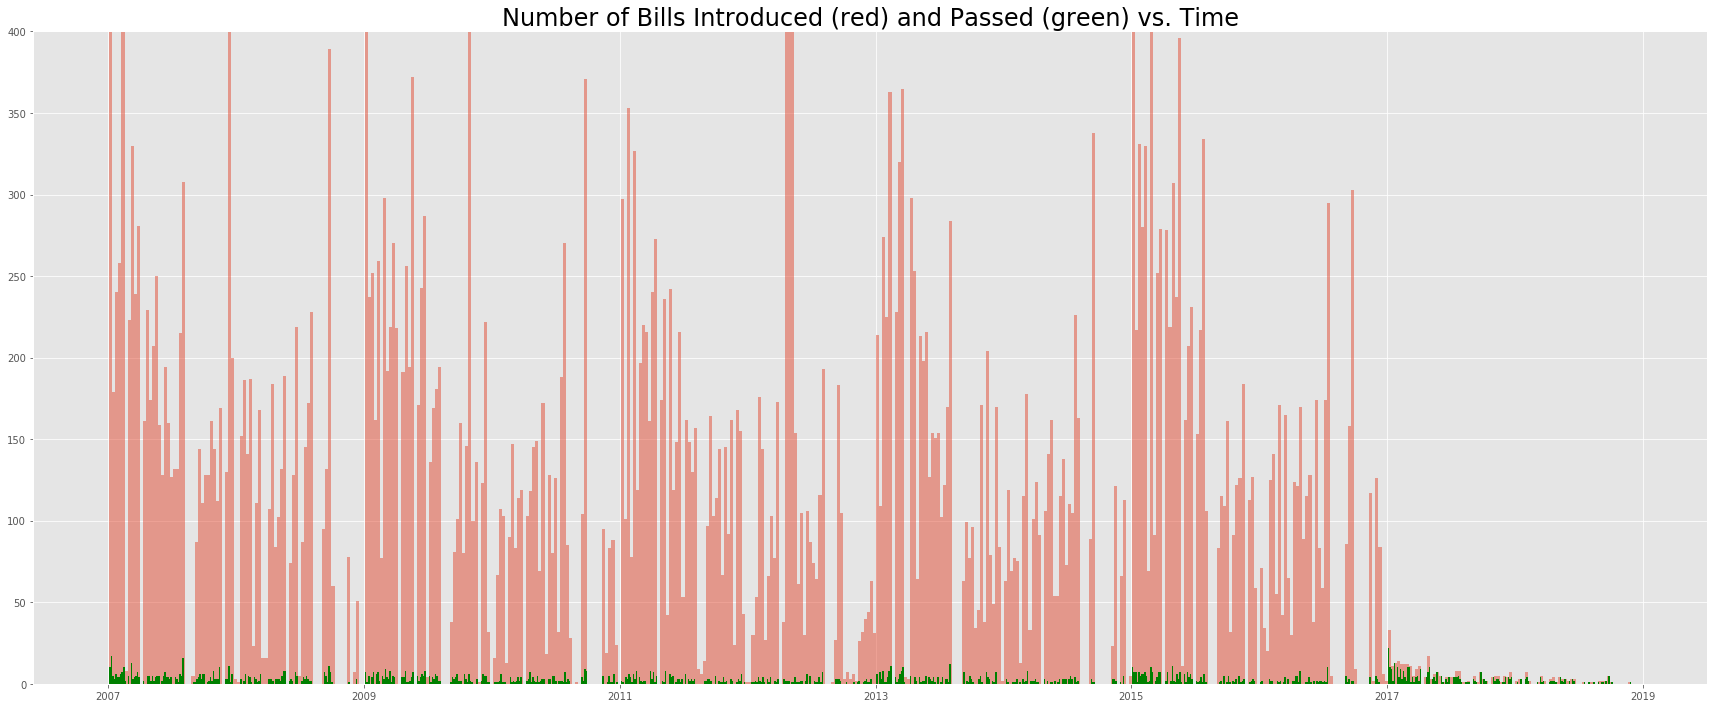

In [4]:
passed_df = data[data['labels'] == 1]

fig = plt.figure(figsize = (30, 12))
ax = fig.add_subplot(111)
ax.set_title('Number of Bills Introduced (red) and Passed (green) vs. Time', fontdict={'fontsize': 24})
ax.hist(data['intro_date'], bins = 500, alpha = .5)
ax.hist(passed_df['intro_date'], bins = 1000, color = 'g')
ax.set_ylim(0, 400)
plt.show()

In [5]:
# non-numeric num_of_cosponsors: S. Rept. 110-184, TXT, All Actions
data = data[(data['num_of_cosponsors'] != 'S. Rept. 110-184') &
           (data['num_of_cosponsors'] != 'TXT') &
           (data['num_of_cosponsors'] != 'All Actions')]

In [6]:
data['num_of_cosponsors'] = data['num_of_cosponsors'].apply(pd.to_numeric)

In [7]:
data.iloc[:5, 10:]

,leg_type,leg_url,num_of_cosponsors,sponsor,sponsor_district,sponsor_party,sponsor_state,bill_char_counts,intro_month,session,labels
865,LAW,https://www.congress.gov/bill/114th-congress/h...,3,"Rep. Chabot, Steve",1,R,OH,5366,12,2,1
890,LAW,https://www.congress.gov/bill/114th-congress/h...,2,"Rep. Radewagen, Aumua Amata Coleman",At Large,R,AS,68574,12,2,1
891,LAW,https://www.congress.gov/bill/114th-congress/h...,1,"Rep. Denham, Jeff",10,R,CA,24935,12,2,1
892,LAW,https://www.congress.gov/bill/114th-congress/h...,2,"Rep. Chaffetz, Jason",3,R,UT,33853,12,2,1
911,LAW,https://www.congress.gov/bill/114th-congress/h...,23,"Rep. Kuster, Ann M.",2,D,NH,3465,12,2,1


In [8]:
# First iteration of Random Forest showed that congress_id 115th is a top feature when measured using 
# average Gini importance. The predictions that users will be looking for will always be from the 
# most recent Congress. Therefore, remove congress_id...

# Second iteration removes num_of_cosponsors and bill_char_counts...
data_features = data.loc[:, [
#                           'congress_id', 
                          'num_of_cosponsors', 
                          'sponsor_party', 
                          'sponsor_state', 
                          'bill_char_counts', 
                          'intro_month', 
                          'session', 
                           'labels']]

In [9]:
# get dummies for intro_month, sponsor_party, sponsor_state, session
data_dumm = pd.get_dummies(data_features, columns = [
#                                             'congress_id', 
                                            'intro_month', 
                                            'sponsor_party', 
                                            'sponsor_state', 
                                            'session'], 
                           drop_first=True)

In [10]:
data_dumm.head()

,num_of_cosponsors,bill_char_counts,labels,intro_month_2,intro_month_3,intro_month_4,intro_month_5,intro_month_6,intro_month_7,intro_month_8,...,sponsor_state_TX,sponsor_state_UT,sponsor_state_VA,sponsor_state_VI,sponsor_state_VT,sponsor_state_WA,sponsor_state_WI,sponsor_state_WV,sponsor_state_WY,session_2
865,3,5366,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
890,2,68574,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
891,1,24935,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
892,2,33853,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
911,23,3465,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
def plot_it(x, y_list, name, labels):
    x = x
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(111)
    ax.set_title(name, fontdict = {'fontsize': 20})
    for y in y_list:
        plt.plot(x, y)
    plt.legend(labels)

    plt.show

In [12]:
y = data_dumm.pop('labels').values.astype(int)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_dumm, y, 
                                                    stratify = y, 
                                                    random_state = 123)

In [37]:
# Iterate through several n_estimators to find best 
n_list = range(600, 640, 2)
r_list = []

print('----------------')
print('Iterating through several n_estimators for a Random Forest model...')

for n in n_list:
    print('--> n = {}'.format(n))
    rf = RandomForestClassifier(n_estimators=n, 
                                max_features = 'auto', 
                                random_state = 123, 
                                n_jobs = -1)
    rf.fit(X_train, y_train)
    
    rf_y_pred = rf.predict(X_test)
    r_list.append(recall_score(y_test, rf_y_pred))


----------------
Iterating through several n_estimators for a Random Forest model...
--> n = 600
--> n = 602
--> n = 604
--> n = 606
--> n = 608
--> n = 610
--> n = 612
--> n = 614
--> n = 616
--> n = 618
--> n = 620
--> n = 622
--> n = 624
--> n = 626
--> n = 628
--> n = 630
--> n = 632
--> n = 634
--> n = 636
--> n = 638


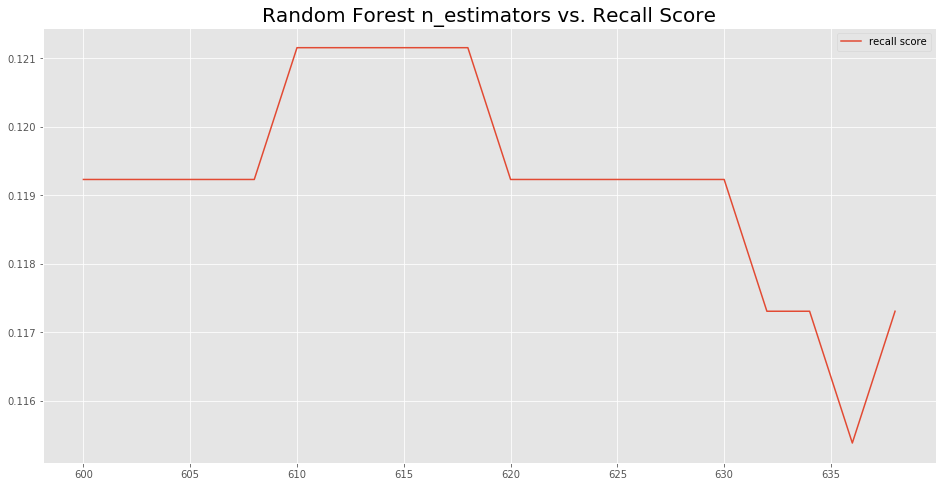

In [38]:
# show graph of scores vs. number of max_features 
x = np.arange(600, 640, 2)
plot_list = [r_list]
graph_name = 'Random Forest n_estimators vs. Recall Score'
labels = ['recall score']

plot_it(x, plot_list, graph_name, labels)

In [44]:
np.argmax(r_list)

5

In [47]:
# random forest classifier
rf = RandomForestClassifier(n_estimators=610, 
                            max_features = 'auto', 
                            random_state = 123, 
                            n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=610, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [48]:
rf_y_pred = rf.predict(X_test)

print('----------------------')
print('----------------------')
print('Random Forest Classification')
print('----------------------')
print('Accuracy score:  {:.2f}'.format(accuracy_score(y_test, rf_y_pred)))
print('Precision score: {:.2f}'.format(precision_score(y_test, rf_y_pred)))
print('Recall score:    {:.2f}'.format(recall_score(y_test, rf_y_pred)))


Text(0.5,0,'Average contribution to information gain')

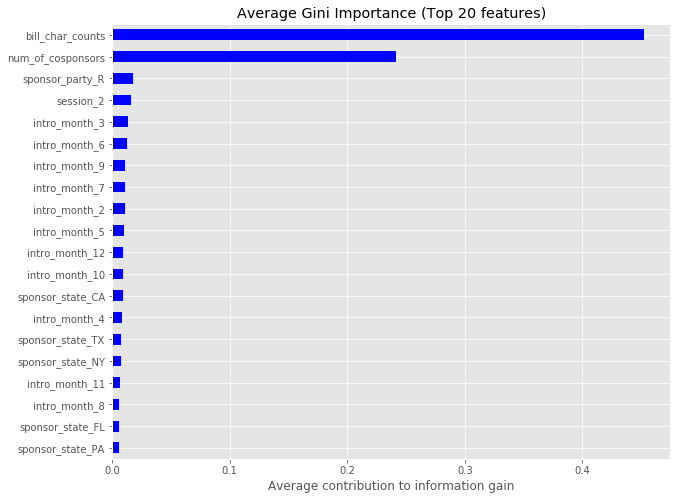

In [19]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train.columns)
feat_scores = feat_scores.sort_values()[::-1][:20][::-1]
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance (Top 20 features)')
ax.set_xlabel('Average contribution to information gain')